<a id='index'></a>
# CIFAR-10 example
In this notebook, both a Multi-Layer Perceptron (MLP) and a Convolutional Neural Network (CNN) are trained using the CIFAR-10 dataset (details on the dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html)).

- [MLP](#mlp) - vanilla neural network
- [CNN](#cnn) - basic CNN
- [Image Augmentation](#image_augmentation) 

## Import the CIFAR-10 dataset

In [1]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


## Visualise the training images

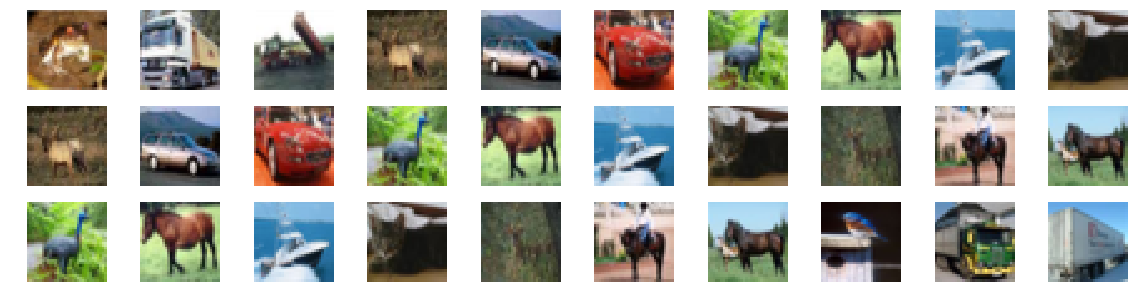

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
for r in range(axes.shape[0]):
    for c in range(axes.shape[1]):
        axes[r][c].imshow(np.squeeze(X_train[r * axes.shape[0] + c]))
        axes[r][c].axis('off')        

## Rescale the images

In [3]:
# [0, 255] -> [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## Preprocess datasets

In [4]:
import keras
from keras.utils import np_utils

# Apply One-Hot encoding
num_labels = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_labels)
y_test = keras.utils.to_categorical(y_test, num_labels)

# Build a Validation set
X_train, X_val = X_train[5000:], X_train[:5000]
y_train, y_val = y_train[5000:], y_train[:5000]

print("X_train shape: {}".format(X_train.shape))
print("Training examples: %d" % X_train.shape[0])
print("Validation examples: %d" % X_val.shape[0])
print("Test examples: %d" % X_test.shape[0])

X_train shape: (45000, 32, 32, 3)
Training examples: 45000
Validation examples: 5000
Test examples: 10000


<a id='mlp'></a>
## A Multi-Layer Perceptron (MLP) 
Vanilla neural network.

[back to index](#index)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()

# Flattening the image into vector results 
# in the loss of spatial information
model.add(Flatten(input_shape=X_train.shape[1:]))

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_labels, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              3073000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 3,590,642
Trainable params: 3,590,642
Non-trainable params: 0
_________________________________________________________________


The MLP model implemented above has **~3.6M** weights to train...

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [7]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='MLP.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer],
                    verbose=2,
                    shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 1.84709, saving model to MLP.weights.best.hdf5
11s - loss: 2.1905 - acc: 0.2660 - val_loss: 1.8471 - val_acc: 0.3274
Epoch 2/20
Epoch 00001: val_loss improved from 1.84709 to 1.80257, saving model to MLP.weights.best.hdf5
10s - loss: 1.8478 - acc: 0.3323 - val_loss: 1.8026 - val_acc: 0.3526
Epoch 3/20
Epoch 00002: val_loss did not improve
10s - loss: 1.8088 - acc: 0.3517 - val_loss: 1.8898 - val_acc: 0.3326
Epoch 4/20
Epoch 00003: val_loss did not improve
10s - loss: 1.7898 - acc: 0.3592 - val_loss: 1.9519 - val_acc: 0.3158
Epoch 5/20
Epoch 00004: val_loss did not improve
11s - loss: 1.7762 - acc: 0.3666 - val_loss: 1.8517 - val_acc: 0.3210
Epoch 6/20
Epoch 00005: val_loss did not improve
11s - loss: 1.7715 - acc: 0.3689 - val_loss: 1.8371 - val_acc: 0.3588
Epoch 7/20
Epoch 00006: val_loss improved from 1.80257 to 1.68551, saving model to MLP.weights.best.hdf5
10s - loss: 1.7664 - acc

### Test the MLP model

In [8]:
model.load_weights('MLP.weights.best.hdf5')

score = model.evaluate(X_test, y_test, verbose=0)

print('\nTest accuracy: %.3f%%' % (score[1] * 100))


Test accuracy: 41.310%


Guessing randomly would have given us accuracy of ~10% (getting 1 in 10 labels right on average).

<a id='cnn'></a>
## Convolutional Neural Network (CNN)
A very basic CNN model.

[back to index](#index)

- [Conv2D](https://keras.io/layers/convolutional/#conv2d) documentation
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) documentation

In [9]:
from keras.layers import (Conv2D, MaxPooling2D, Flatten, 
                          Dense, Dropout)

model = Sequential()

# N.B. strides=1 by default
model.add(Conv2D(filters=16,
                 kernel_size=2,
                 padding='same',
                 activation='relu',
                 input_shape=(32, 32, 3)))

# N.B. strides=pool_size and padding='valid' by default
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,
                 kernel_size=2,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))

# Dropout prob. of 30%
model.add(Dropout(0.3))

# Flattens last spatial layer
model.add(Flatten())

# Fully connected layer of 500 nodes
model.add(Dense(500, activation='relu'))

model.add(Dropout(0.4))

# Output layer
model.add(Dense(num_labels, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)          0         
__________

Compared to the previously implemented **MLP**, the **CNN** model has ~7 times fewer weights (*3.6M vs 0.5M*).

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

[EarlyStopping](https://keras.io/callbacks/#earlystopping) documentation.

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath='CNN.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-4, 
                           patience=10, 
                           verbose=1,
                           mode='auto')

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer, early_stop],
                    verbose=2,
                    shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.31173, saving model to CNN.weights.best.hdf5
9s - loss: 1.5988 - acc: 0.4207 - val_loss: 1.3117 - val_acc: 0.5360
Epoch 2/100
Epoch 00001: val_loss improved from 1.31173 to 1.12242, saving model to CNN.weights.best.hdf5
9s - loss: 1.2895 - acc: 0.5407 - val_loss: 1.1224 - val_acc: 0.6026
Epoch 3/100
Epoch 00002: val_loss did not improve
9s - loss: 1.1764 - acc: 0.5846 - val_loss: 1.1480 - val_acc: 0.5946
Epoch 4/100
Epoch 00003: val_loss improved from 1.12242 to 0.99429, saving model to CNN.weights.best.hdf5
9s - loss: 1.0993 - acc: 0.6129 - val_loss: 0.9943 - val_acc: 0.6542
Epoch 5/100
Epoch 00004: val_loss improved from 0.99429 to 0.99177, saving model to CNN.weights.best.hdf5
9s - loss: 1.0624 - acc: 0.6331 - val_loss: 0.9918 - val_acc: 0.6504
Epoch 6/100
Epoch 00005: val_loss did not improve
8s - loss: 1.0281 - acc: 0.6456 - val_loss: 1.1538 - val_acc: 0.6510
Epoch 7/100
Epoch

### Test the CNN model

In [12]:
model.load_weights('CNN.weights.best.hdf5')

score = model.evaluate(X_test, y_test, verbose=0)

print('\nTest accuracy: %.3f%%' % (score[1] * 100))


Test accuracy: 68.010%


<a id='image_augmentation'></a>
## Image Augmentation
Attempt at improving the accuracy with [image augmentation](https://keras.io/preprocessing/image/). Detailed [implementation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) that uses augmentation to boost performance on a Kaggle dataset.

[back to index](#index)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally (10% of total width)
                              height_shift_range=0.1, # randomly shift images vertically (10% of total height)
                              horizontal_flip=True) # randomly flip images horizontally

data_gen.fit(X_train)

### Visualise the augmented images

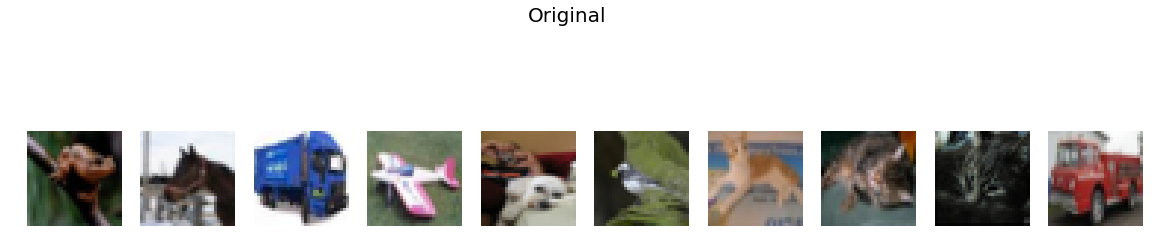

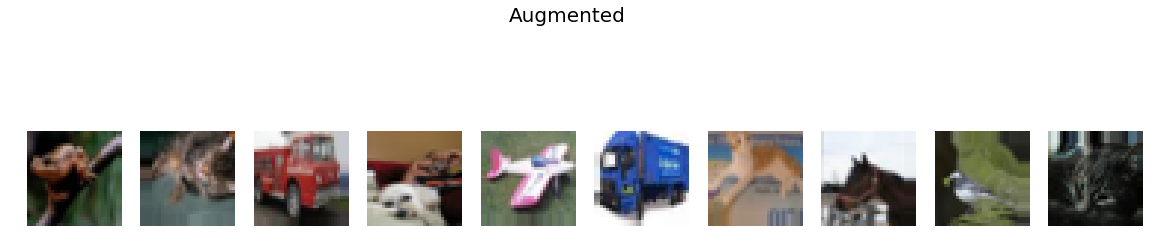

In [14]:
fig, axes = plt.subplots(ncols=10, figsize=(20, 5))
for c in range(axes.shape[0]):
    axes[c].imshow(np.squeeze(X_train[c]))
    axes[c].axis('off') 
    fig.suptitle('Original', fontsize=20)
    
fig, axes = plt.subplots(ncols=10, figsize=(20, 5))
for batch in data_gen.flow(X_train[:axes.shape[0]], 
                           batch_size=axes.shape[0]):    
    for c in range(axes.shape[0]):
        axes[c].imshow(np.squeeze(batch[c]))
        axes[c].axis('off') 
    fig.suptitle('Augmented', fontsize=20)
    break

Run the previous **CNN** model with a *slight change...*

In [17]:
batch_size = 32
epochs = 100
steps_per_epoch = X_train.shape[0] / batch_size

checkpointer = ModelCheckpoint(filepath='CNN.augmented.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-4, 
                           patience=10, 
                           verbose=1,
                           mode='min')

history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X_val, y_val),
                              callbacks=[checkpointer, early_stop],
                              verbose=2)

Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.07398, saving model to CNN.augmented.weights.best.hdf5
14s - loss: 1.1819 - acc: 0.5997 - val_loss: 1.0740 - val_acc: 0.6388
Epoch 2/100
Epoch 00001: val_loss improved from 1.07398 to 0.97208, saving model to CNN.augmented.weights.best.hdf5
14s - loss: 1.2001 - acc: 0.5950 - val_loss: 0.9721 - val_acc: 0.6788
Epoch 3/100
Epoch 00002: val_loss did not improve
14s - loss: 1.2133 - acc: 0.5927 - val_loss: 1.3076 - val_acc: 0.5966
Epoch 4/100
Epoch 00003: val_loss did not improve
14s - loss: 1.2317 - acc: 0.5855 - val_loss: 1.0496 - val_acc: 0.6676
Epoch 5/100
Epoch 00004: val_loss did not improve
14s - loss: 1.2410 - acc: 0.5848 - val_loss: 1.1656 - val_acc: 0.6218
Epoch 6/100
Epoch 00005: val_loss did not improve
14s - loss: 1.2521 - acc: 0.5800 - val_loss: 0.9854 - val_acc: 0.6660
Epoch 7/100
Epoch 00006: val_loss did not improve
14s - loss: 1.2583 - acc: 0.5788 - val_loss: 1.1094 - val_acc: 0.6220
Epoch 8/100
Epoch 00007: val_los

### Test the CNN model trained on the augmented dataset

In [18]:
model.load_weights('CNN.augmented.weights.best.hdf5')

score = model.evaluate(X_test, y_test, verbose=0)

print('\nTest accuracy: %.3f%%' % (score[1] * 100))


Test accuracy: 67.140%
